### Logistic Regression Implementation

In [ ]:
from Bio import SeqIO
import pandas as pd
import numpy as np
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

### Load Data

In [3]:
import numpy as np

X = np.load("chr1/features/chr1_windows_X_unnorm.npy")
y = np.load("chr1/features/chr1_windows_y.npy")

print(X.shape, y.shape)
print("Successfully Loaded Data!")

(49869, 6) (49869,)
Successfully Loaded Data!


### Pipeline

Standard Scale and Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TunedThresholdClassifierCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.metrics import (
    balanced_accuracy_score, roc_auc_score, average_precision_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, shuffle=True, stratify = y, random_state = 561)

pipeline = Pipeline([("scaler", StandardScaler()), 
                      ("clf", LogisticRegression(
                          penalty = 'l2',
                          class_weight = "balanced",
                          max_iter = 500,
                          solver = "lbfgs"
                      ))])

### CV

In [ ]:
param_grid = {"clf__C": np.logspace(-4, 2, 30)}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring={
        "bal_acc": "balanced_accuracy",
        "roc_auc": "roc_auc",
        "ap": "average_precision",
    },
    refit="bal_acc",   # choose the model that maximizes balanced accuracy
    n_jobs=-1,
)
search.fit(X_train, y_train)
best = search.best_estimator_

print("Best C:", search.best_params_["clf__C"])
print("CV mean balanced accuracy:", search.cv_results_["mean_test_bal_acc"][search.best_index_])


Best C: 0.5298316906283708
CV mean balanced accuracy: 0.7493754869475012


### Evaluating with Balanced/PR Metrics

Test balanced accuracy: 0.7399796975136637
Test ROC AUC: 0.8276873236726724
Test PR AUC (AP): 0.9648007507838937
              precision    recall  f1-score   support

           0       0.31      0.76      0.44      1396
           1       0.95      0.72      0.82      8578

    accuracy                           0.73      9974
   macro avg       0.63      0.74      0.63      9974
weighted avg       0.86      0.73      0.77      9974



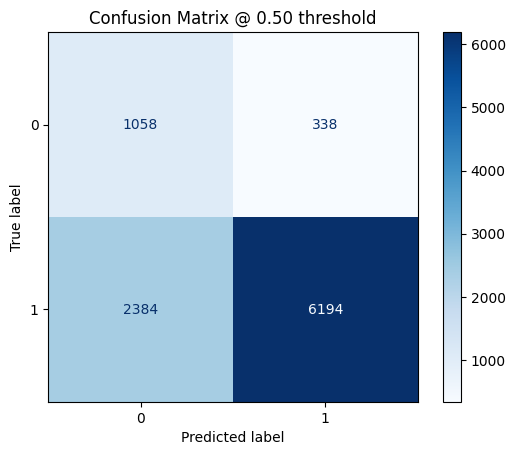

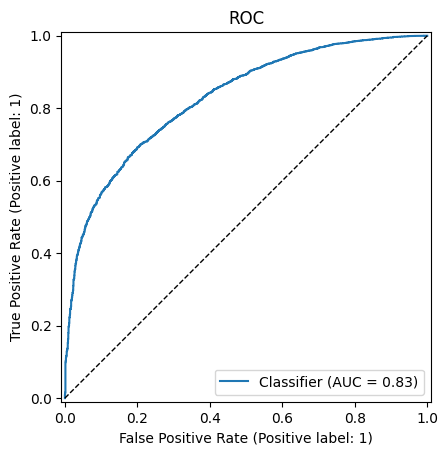

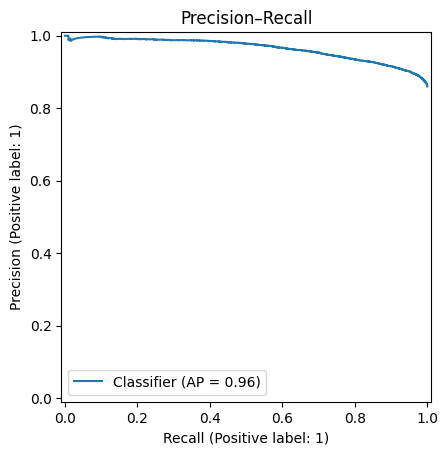

In [ ]:
y_pred = best.predict(X_test)
y_proba = best.predict_proba(X_test)[:, 1]

print("Test balanced accuracy:", balanced_accuracy_score(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_proba))
print("Test PR AUC (AP):", average_precision_score(y_test, y_proba))
print(classification_report(y_test, y_pred))  # keep for detail

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Confusion Matrix @ 0.50 threshold")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.plot([0, 1], [0, 1], "k--", linewidth=1)  # random classifier line
plt.title("ROC")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title("Precision–Recall")
plt.show()

### Threshold Tuning

In [ ]:
classifier_tuned = TunedThresholdClassifierCV(
    best, scoring="balanced_accuracy"
).fit(X_train, y_train)
thr = classifier_tuned.best_threshold_
print(f"Balanced-accuracy-optimal threshold: {thr:.3f}")

y_pred_thr = classifier_tuned.predict(X_test)
print("Balanced accuracy (tuned):", balanced_accuracy_score(y_test, y_pred_thr))
print(classification_report(y_test, y_pred_thr))

Balanced-accuracy-optimal threshold: 0.532
Balanced accuracy (tuned): 0.7451066765718393
              precision    recall  f1-score   support

           0       0.30      0.80      0.43      1396
           1       0.95      0.69      0.80      8578

    accuracy                           0.71      9974
   macro avg       0.63      0.75      0.62      9974
weighted avg       0.86      0.71      0.75      9974



Confusion matrix @ tuned threshold:



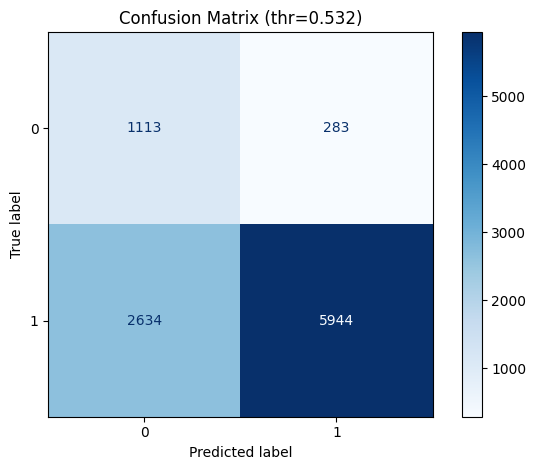

In [ ]:
cm = confusion_matrix(y_test, y_pred_thr)
print("Confusion matrix @ tuned threshold:\n")

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (thr={thr:.3f})")
plt.tight_layout()
plt.show()

### Code For Visualizing Distributions of Features Post-Scaling

In [9]:
"""
scaled_train_df = pd.DataFrame(X_train_norm, columns = ['MGW', 'ProT', 'Roll', 'Opening', 'Buckle', 'GC Content'])

fig, axes = plt.subplots(1, 6, figsize=(15, 5)) # Create a figure and a set of subplots
for i, col in enumerate(scaled_train_df.columns):
    axes[i].hist(scaled_train_df[col], bins=30, edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()
"""

"\nscaled_train_df = pd.DataFrame(X_train_norm, columns = ['MGW', 'ProT', 'Roll', 'Opening', 'Buckle', 'GC Content'])\n\nfig, axes = plt.subplots(1, 6, figsize=(15, 5)) # Create a figure and a set of subplots\nfor i, col in enumerate(scaled_train_df.columns):\n    axes[i].hist(scaled_train_df[col], bins=30, edgecolor='black')\n    axes[i].set_title(f'Histogram of {col}')\n    axes[i].set_xlabel('Value')\n    axes[i].set_ylabel('Frequency')\nplt.tight_layout() # Adjust layout to prevent overlapping titles/labels\nplt.show()\n"

### Bootstrap

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from sklearn.base import clone

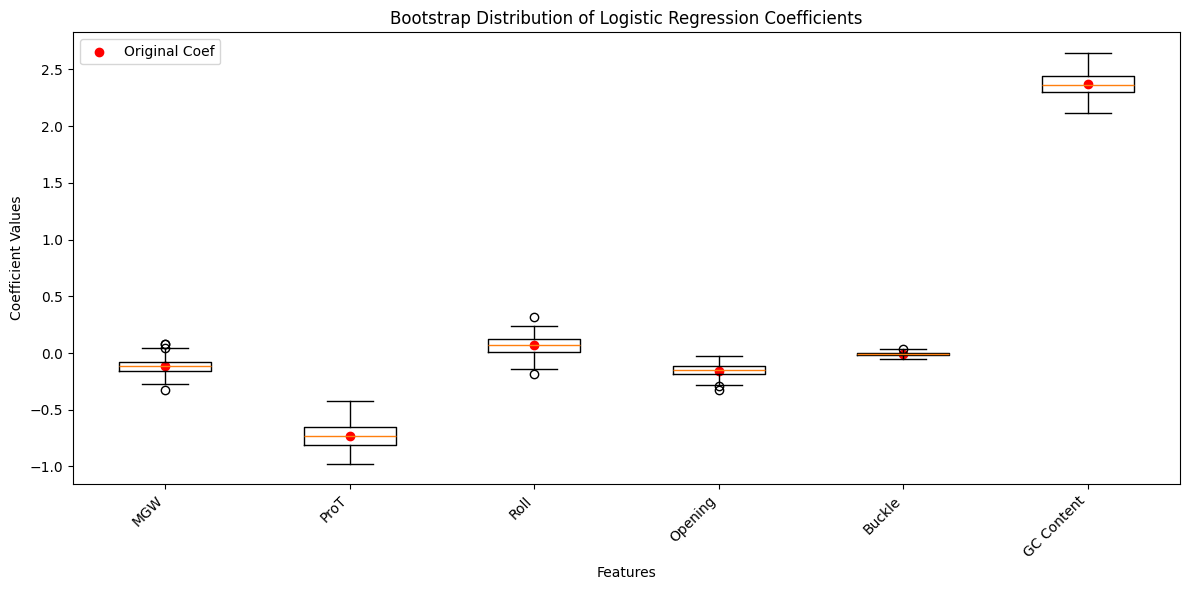

In [ ]:
best_C = search.best_params_["clf__C"]          # already found via CV
best_coef = best.named_steps["clf"].coef_[0]

bootstraps = 200
n_features = X_train.shape[1]
coef_matrix = np.zeros((bootstraps, n_features))

template = clone(best)  # preserves C, class_weight, scaling inside pipeline

for i in range(bootstraps):
    Xb, yb = resample(
        X_train, y_train,
        replace=True,
        n_samples=len(X_train),
        stratify=y_train,
        random_state=561 + i,
    )
    model = clone(template)
    model.fit(Xb, yb)
    coef_matrix[i, :] = model.named_steps["clf"].coef_[0]

feature_names = ["MGW", "ProT", "Roll", "Opening", "Buckle", "GC Content"]
plt.figure(figsize=(12,6))
plt.boxplot(coef_matrix)

plt.scatter(range(1, n_features+1), best_coef,
            color='red', marker='o', label='Original Coef')

plt.xlabel("Features")
plt.ylabel("Coefficient Values")
plt.title("Bootstrap Distribution of Logistic Regression Coefficients")

plt.xticks(ticks=range(1, n_features+1),
           labels=feature_names,
           rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
# 1. Calculate Standard Deviation (Stability of the weight)
std_devs = np.std(coef_matrix, axis=0)

# 2. Calculate 95% Confidence Intervals (2.5th and 97.5th percentiles)
ci_lower = np.percentile(coef_matrix, 2.5, axis=0)
ci_upper = np.percentile(coef_matrix, 97.5, axis=0)

# 3. Print a clean summary table for your paper
print(f"{'Feature':<12} {'Orig Coef':<10} {'Std Dev':<10} {'95% CI'}")
print("-" * 55)

for i, name in enumerate(feature_names):
    print(f"{name:<12} {best_coef[i]:<10.4f} {std_devs[i]:<10.4f} [{ci_lower[i]:.3f}, {ci_upper[i]:.3f}]")

Feature      Orig Coef  Std Dev    95% CI
-------------------------------------------------------
MGW          -0.1182    0.0702     [-0.240, 0.028]
ProT         -0.7284    0.1096     [-0.918, -0.515]
Roll         0.0696     0.0833     [-0.100, 0.208]
Opening      -0.1549    0.0526     [-0.261, -0.050]
Buckle       -0.0105    0.0164     [-0.040, 0.021]
GC Content   2.3673     0.1034     [2.160, 2.555]


In [12]:
# 1. Calculate Statistics
boot_mean = np.mean(coef_matrix, axis=0)  # The average coefficient
boot_std  = np.std(coef_matrix, axis=0)   # The stability
ci_lower  = np.percentile(coef_matrix, 2.5, axis=0)
ci_upper  = np.percentile(coef_matrix, 97.5, axis=0)

# 2. Print Summary Table
print(f"{'Feature':<12} {'Orig':<8} {'Mean':<8} {'Std':<8} {'95% CI'}")
print("-" * 60)

for i, name in enumerate(feature_names):
    # Check for bias: is Orig close to Mean?
    print(f"{name:<12} {best_coef[i]:<8.3f} {boot_mean[i]:<8.3f} {boot_std[i]:<8.3f} [{ci_lower[i]:.3f}, {ci_upper[i]:.3f}]")

Feature      Orig     Mean     Std      95% CI
------------------------------------------------------------
MGW          -0.118   -0.113   0.070    [-0.240, 0.028]
ProT         -0.728   -0.730   0.110    [-0.918, -0.515]
Roll         0.070    0.065    0.083    [-0.100, 0.208]
Opening      -0.155   -0.153   0.053    [-0.261, -0.050]
Buckle       -0.010   -0.009   0.016    [-0.040, 0.021]
GC Content   2.367    2.366    0.103    [2.160, 2.555]
